<a href="https://colab.research.google.com/github/VictorZwart/ScriptieOffensiveLanguage/blob/main/BiLSTM/scriptie_code_bilstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BiLSTM

In [58]:
# get gpu specs
!nvidia-smi
# Tesla K80 (11441MiB) = bad
# Tesla T4  (15109MiB) = good

Wed Apr 28 11:48:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

First import all the necessary packages

In [59]:
import warnings
warnings.filterwarnings('ignore')
import urllib
import shutil
import sys

# Modules for data manipulation
import numpy as np
import pandas as pd
import re
import csv

# Modules for visualization
import matplotlib.pyplot as plt
import seaborn as sb

# Tools for preprocessing input data
from bs4 import BeautifulSoup
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Tools for creating ngrams and vectorizing input data
from gensim.models import Word2Vec, Phrases

# Tools for building a model
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences


# Tools for assessing the quality of model prediction
from sklearn.metrics import accuracy_score, confusion_matrix

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Download the Coosto model 

In [60]:
# upload data
from google.colab import files
uploaded = files.upload()


Saving batch_1_victor.csv to batch_1_victor.csv


In [61]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIG_SIZE = 16
LARGE_SIZE = 20

params = {
    'figure.figsize': (16, 8),
    'font.size': SMALL_SIZE,
    'xtick.labelsize': MEDIUM_SIZE,
    'ytick.labelsize': MEDIUM_SIZE,
    'legend.fontsize': BIG_SIZE,
    'figure.titlesize': LARGE_SIZE,
    'axes.titlesize': MEDIUM_SIZE,
    'axes.labelsize': BIG_SIZE
}
plt.rcParams.update(params)

Import Data

In [79]:
full_data = []

with open('batch_1_victor.csv', encoding='utf-8') as f:
    reader = csv.DictReader(f, delimiter='\t')
    for index, line in enumerate(reader):
            # LABELS.index is required, because train_model only works with numeric labels

            full_data.append([line['text'], line['explicitness']])

df_full = pd.DataFrame(full_data)
df_full.columns = ["text", "explicitness"]
train, test = train_test_split(df_full, test_size=0.2,
                               shuffle=True,
                                random_state=42)




ValueError: ignored

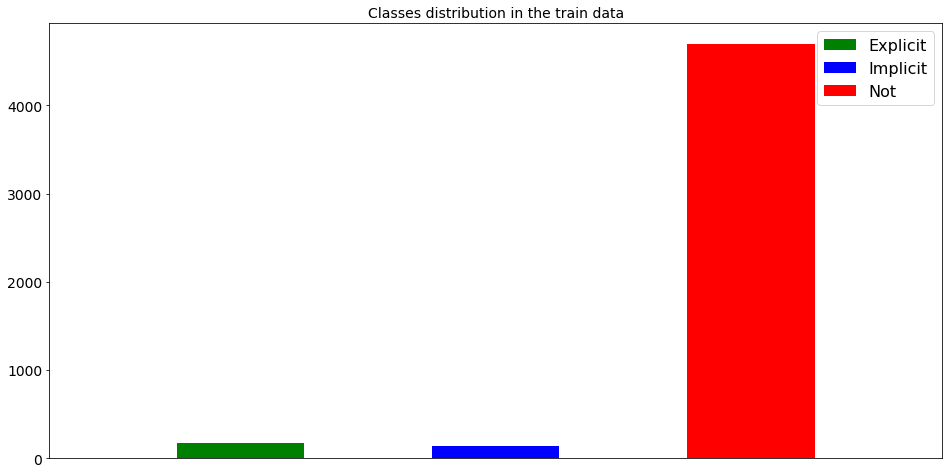

In [63]:
plt.hist(train[train.explicitness == "EXPLICIT"].explicitness,
         bins=2, color='green', label='Explicit')
plt.hist(train[train.explicitness == "IMPLICIT"].explicitness,
         bins=2, color='blue', label='Implicit')
plt.hist(train[train.explicitness == "NOT"].explicitness,
         bins=2, color='red', label='Not')
plt.title('Classes distribution in the train data')
plt.xticks([])
plt.xlim(-0.5, 3)
plt.legend()
plt.show()

In [64]:
all_reviews = np.array([], dtype=str)
all_reviews = np.concatenate((all_reviews, df_full["text"]), axis=0)
print('Total number of reviews:', len(all_reviews))
print(all_reviews)

Total number of reviews: 6266
['#nieuwstwitter In de wandelgangen: Chelsea wil stunten met sterren van Arsenal en Everton https://t.co/6jlmRwEmpT #voetbal'
 '@Joep045 @Het_OM @NUnl En wij blijven het massaal pikken. In fatsoenlijke landen had al lang de pleuris uitgebroken en had de hele gerechtelijke en politieke macht al lang gelyncht geweest.'
 'Ik lees de krant in ochtendlicht en luister naar Sufjan Stevens en het geschreeuw van mijn onderburen en voor het eerst sinds lang mis ik iemand die hier naast me kan zitten, samen met koffie en koek.'
 ...
 '@JumboSupermarkt jammer dat als je voor bijna €100 de week boodschappen besteld, de andijvie maar tot maandag houdbaar is☹️ https://t.co/x02hUaSyQL'
 'Canon Pixma MG4250 Mijn MG 4250 pakt het papier niet meer, er is niets gebeurt, hoe los ik dit op. https://t.co/0dRK6QAgcZ'
 'sprout_nl: Meer geld naar startups, minder geld naar scaleups https://t.co/qBuVDbLJmy https://t.co/CotzSx7wts']


In [65]:
def demoModel(inputFile):
    # Let's not presume gensim installation until needed
    import gensim
    sys.stderr.write("Loading model...\n")
    model = gensim.models.KeyedVectors.load_word2vec_format(inputFile, binary=True)
    sys.stderr.write("Model loaded\n")

    return model

def downloadModel():
    modelUrl = "https://github.com/coosto/dutch-word-embeddings/releases/download/v1.0/model.bin"


    # Request model data
    try:
        request = urllib.request.Request(modelUrl)
        with urllib.request.urlopen(request) as response, open("/content/drive/MyDrive/Scriptie/code/Coosto", 'wb') as fp:
            shutil.copyfileobj(response, fp)
            sys.stderr.write("Model saved: {}\n".format(fp.name))
        return "/content/drive/MyDrive/Scriptie/code/Coosto"
    except urllib.error.HTTPError as error:
        sys.stderr.write("Error fetching model from github.com - {}\n".format(error))
        sys.stderr.write("{}".format(error.read()))
        exit(1)



In [66]:
model = downloadModel()

Model saved: /content/drive/MyDrive/Scriptie/code/Coosto


In [67]:
coosto_model = demoModel(model)
coosto_model.most_similar("pilsje")

Loading model...
Model loaded


[('biertje', 0.9145998954772949),
 ('glas_bier', 0.7679998874664307),
 ('wijntje', 0.7564073801040649),
 ('paar_biertjes', 0.7425606846809387),
 ('pilsjes', 0.7367861270904541),
 ('biertjes', 0.7344973087310791),
 ('colaatje', 0.7323644161224365),
 ('pilske', 0.724961519241333),
 ('borreltje', 0.7243227958679199),
 ('pils', 0.7234804630279541)]

In [99]:
def vectorize_data(data, vocab: dict) -> list:
    print('Vectorize sentences...', end='\r')
    keys = list(vocab.keys())
    filter_unknown = lambda word: vocab.get(word, None) is not None
    encode = lambda review: list(map(keys.index, filter(filter_unknown, review)))
    vectorized = list(map(encode, data))
    print('Vectorize sentences... (done)')
    return vectorized

print('Convert sentences to sentences with ngrams...', end='\r')
print('Convert sentences to sentences with ngrams... (done)')
X_pad = pad_sequences(
    sequences=vectorize_data(all_reviews, vocab=coosto_model.wv.vocab),
    maxlen=coosto_model.vector_size,
    padding='post')
print('Transform sentences to sequences... (done)')

Convert sentences to sentences with ngrams... (done)
Vectorize sentences... (done)
Transform sentences to sequences... (done)


In [115]:
Y_train_data = df_full["explicitness"].factorize()[0]



X_train, X_test, y_train, y_test = train_test_split(
    X_pad,
    Y_train_data,
    test_size=0.2,
    shuffle=True,
    random_state=69)

In [116]:
def build_model(embedding_matrix: np.ndarray, input_length: int):
    model = Sequential()
    model.add(Embedding(
        input_dim = embedding_matrix.shape[0],
        output_dim = embedding_matrix.shape[1], 
        input_length = input_length,
        weights = [embedding_matrix],
        trainable=False))
    model.add(Bidirectional(LSTM(128, recurrent_dropout=0.1)))
    model.add(Dropout(0.25))
    model.add(Dense(64))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    return model

In [117]:
bilstm_model = build_model(
    embedding_matrix=coosto_model.wv.vectors,
    input_length=input_length)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 300)          75143700  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               439296    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 75,599,509
Trainable params: 455,809
Non-trainable params: 75,143,700
____________________________________

In [119]:
bilstm_model.compile(
    loss="binary_crossentropy",
    optimizer='adam',
    metrics=['accuracy'])

history = bilstm_model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    batch_size=100,
    epochs=5)

Epoch 1/5
51/51 [==============================] - 92s 2s/step - loss: 0.3246 - accuracy: 0.9373 - val_loss: 0.3025 - val_accuracy: 0.9426
Epoch 2/5
51/51 [==============================] - 90s 2s/step - loss: 0.3283 - accuracy: 0.9360 - val_loss: 0.3058 - val_accuracy: 0.9426
Epoch 3/5
51/51 [==============================] - 90s 2s/step - loss: 0.3360 - accuracy: 0.9315 - val_loss: 0.3024 - val_accuracy: 0.9426
Epoch 4/5
51/51 [==============================] - 86s 2s/step - loss: 0.3330 - accuracy: 0.9305 - val_loss: 0.3030 - val_accuracy: 0.9426
Epoch 5/5
51/51 [==============================] - 84s 2s/step - loss: 0.3206 - accuracy: 0.9371 - val_loss: 0.3066 - val_accuracy: 0.9426


Meer visualisatie

In [120]:
def plot_confusion_matrix(y_true, y_pred, ax, class_names, vmax=None,
                          normed=True, title='Confusion matrix'):
    matrix = confusion_matrix(y_true,y_pred)
    if normed:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    sb.heatmap(matrix, vmax=vmax, annot=True, square=True, ax=ax,
               cmap=plt.cm.Blues_r, cbar=False, linecolor='black',
               linewidths=1, xticklabels=class_names)
    ax.set_title(title, y=1.20, fontsize=16)
    #ax.set_ylabel('True labels', fontsize=12)
    ax.set_xlabel('Predicted labels', y=1.10, fontsize=12)
    ax.set_yticklabels(class_names, rotation=0)

In [122]:
y_train_pred = bilstm_model.predict_classes(X_train)
y_test_pred = bilstm_model.predict_classes(X_test)

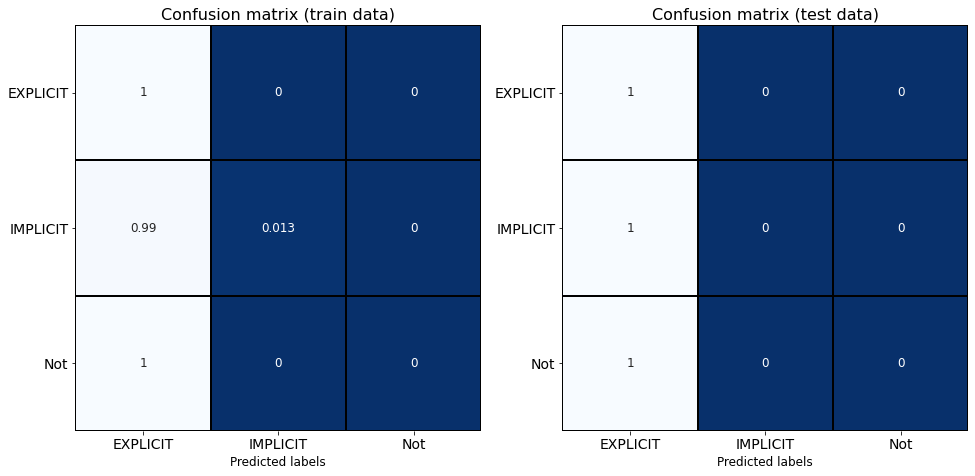

In [131]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2)
plot_confusion_matrix(y_train, y_train_pred, ax=axis1,
                      title='Confusion matrix (train data)',
                      class_names=['EXPLICIT', 'IMPLICIT', "Not"])
plot_confusion_matrix(y_test, y_test_pred, ax=axis2,
                      title='Confusion matrix (test data)',
                      class_names=['EXPLICIT', 'IMPLICIT', "Not"])

{'loss': [0.33290478587150574, 0.3279065191745758, 0.32427510619163513, 0.3219793140888214, 0.31652840971946716], 'accuracy': [0.9355546832084656, 0.9353551268577576, 0.9351556301116943, 0.9351556301116943, 0.9353551268577576], 'val_loss': [0.30251938104629517, 0.3058440387248993, 0.3024248480796814, 0.30297085642814636, 0.3065956234931946], 'val_accuracy': [0.9425837397575378, 0.9425837397575378, 0.9425837397575378, 0.9425837397575378, 0.9425837397575378]}


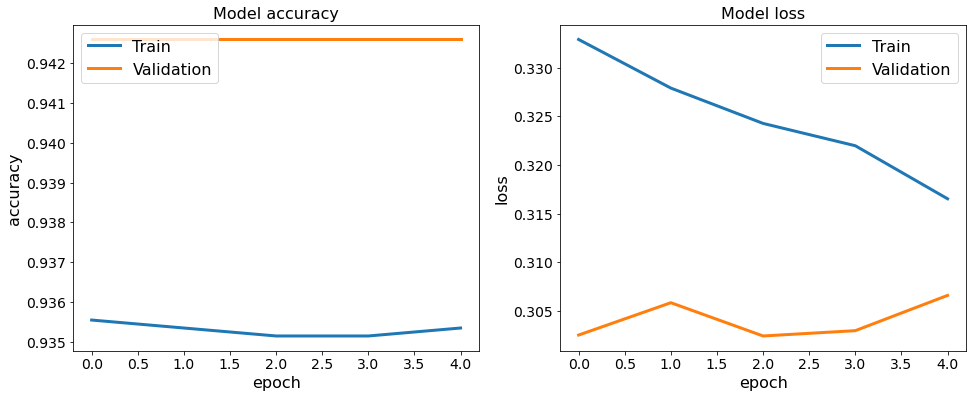

In [129]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
print(history.history)
# summarize history for accuracy
axis1.plot(history.history['accuracy'], label='Train', linewidth=3)
axis1.plot(history.history['val_accuracy'], label='Validation', linewidth=3)
axis1.set_title('Model accuracy', fontsize=16)
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='upper left')

# summarize history for loss
axis2.plot(history.history['loss'], label='Train', linewidth=3)
axis2.plot(history.history['val_loss'], label='Validation', linewidth=3)
axis2.set_title('Model loss', fontsize=16)
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.show()